In [132]:
import json
import os
import pprint
import datetime as dt


class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [(timestamp, time_ms, cpu_usage)]
        self.time_ms = []
        self.cpu_usage = []
        self.timestamp = []
    
    def add_timestamp(self, time_ms, cpu_usage, timestamp):
        self.value.append((timestamp, time_ms, cpu_usage))
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: (x[0], float(x[1]), float(x[2])), self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
    
    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        #print(all_timestamp)
        #print(self.timestamp)
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.time_ms[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage


dict = {}
query_num = 0
all_timestamp =[]

for filename in os.listdir("/root/db_agent/data"):
   with open(os.path.join("/root/db_agent/data", filename), 'r') as f:
       file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
       all_timestamp.append(file_datetime)
       text = json.load(f)
       performance_schema = text['metrics_data']['global']['performance_schema']
       threads = performance_schema['threads']       
       tid_dict = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
       cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
       events_statements_history = performance_schema['events_statements_history']

       for event in events_statements_history:
        digest = event['digest']
        if digest is None:
            continue
        #print(type(digest))
        thread_id = event['thread_id']
        digest_text = event['digest_text']
        if digest in dict.keys():
            dict[digest].add_timestamp(event['time_ms'], cpu_usage[str(tid_dict[thread_id])], file_datetime)
        else:
            temp = digest_query(query_num, digest, digest_text, event['time_ms'], cpu_usage[str(tid_dict[thread_id])], file_datetime)
            dict[digest] = temp
            query_num+=1

In [133]:
def Average(lst):
    return sum(lst) / len(lst)
all_timestamp.sort()
rank_list = []
dict_by_id={}
for query in dict:
    query_id = dict[query].query_id
    dict_by_id[query_id] = dict[query]
    dict[query].sort_timestamp()
    rank_list.append((dict[query].query_id, Average(dict[query].time_ms), Average(dict[query].cpu_usage)))
    #print(dict[query].time_ms)
    dict[query].add_missing_value(all_timestamp)
    #print(dict[query].time_ms)

time_top5 = sorted(rank_list, key=lambda x:-x[1])[:5]
cpu_top5 = sorted(rank_list, key=lambda x:-x[2])[:5]

time_top5_qid = [i[0] for i in time_top5]
cpu_top5_qid = [i[0] for i in cpu_top5]

print(time_top5_qid)
print(cpu_top5_qid)

[44, 50, 2, 34, 15]
[43, 50, 48, 38, 23]


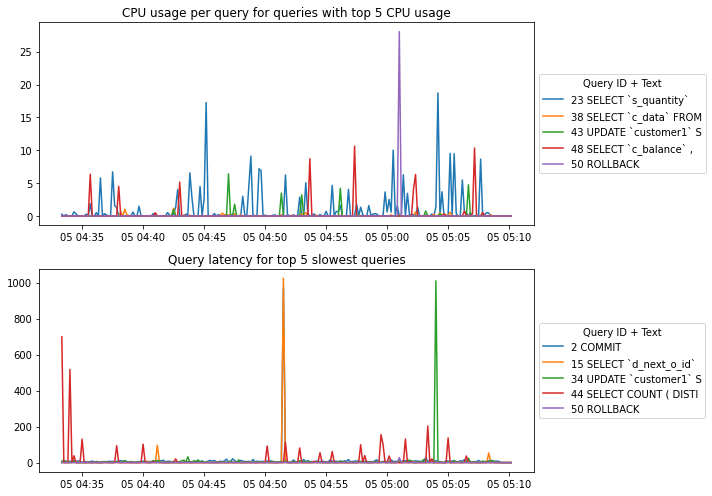

In [139]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math



#plt.plot(xs[s1mask], series1[s1mask], linestyle='-', marker='o')
#plt.plot(xs[s2mask], series2[s2mask], linestyle='-', marker='o')

#plt.figure(figsize=(10, 7))#, default: rcParams["figure.figsize"]
fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
bottom1 = np.zeros(len(all_timestamp))
bottom2 = np.zeros(len(all_timestamp))

for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in time_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y2 = np.array(dict[query].time_ms, dtype=np.float64)
        #print(dict[query].query_id)
        #print(x)
        #print(y2)
        
        axs[1].plot(x, y2, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20])#, bottom = bottom2)
        #y2_max = max(y2_max, max(y2))
        bottom2 = y2 + bottom2
    
    if dict[query].query_id in cpu_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y1 = np.array(dict[query].cpu_usage, dtype=np.float64)
        #y1_max = max(y1_max, max(y1))
        axs[0].plot(x, y1, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20])#, bottom = bottom1)
        #print(dict[query].query_id)
        #print(x)
        #print(y1)
        bottom1 = y1 + bottom1
    #plt.plot(x,y, label=dict[query].query_id)
    
    #break

#axs[0].set_yticks(np.linspace(0,y1_max,10))
axs[0].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[0].set_title("CPU usage per query for queries with top 5 CPU usage")
#axs[1].set_yticks(np.linspace(0,y2_max,10))
axs[1].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title("Query latency for top 5 slowest queries")


plt.tight_layout()

#plt.legend()
plt.show()


2
15
23
34
38
43
44
48
50
50


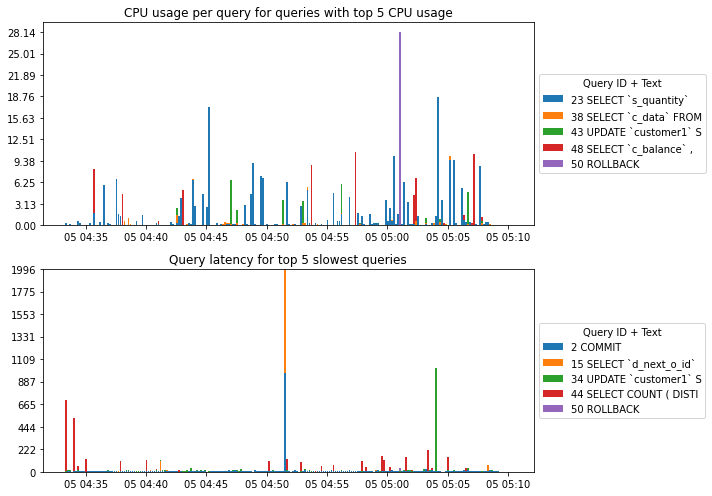

In [164]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math


fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
bottom1 = np.zeros(len(all_timestamp))
bottom2 = np.zeros(len(all_timestamp))
def sumzip(*items):
    return [sum(values) for values in zip(*items)]

for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in cpu_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y1 = np.array(dict[query].cpu_usage, dtype=np.float64)
        #y1_max = max(y1_max, max(y1))
        axs[0].bar(x, y1, width = 0.0001, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20], bottom = bottom1)
        print(dict[query].query_id)
        #print(x)
        #print(y1)
        bottom1 = y1 + bottom1


    if dict[query].query_id in time_top5_qid:
        qid=dict[query].query_id
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y2 = np.array(dict[query].time_ms, dtype=np.float64)
        print(dict[query].query_id)
        #print(x)
        #print(y2)
        
        axs[1].bar(x, y2, width = 0.0001, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20], bottom = bottom2)
        #y2_max = max(y2_max, max(y2))
        bottom2 = y2 + bottom2
    


axs[0].set_yticks(np.linspace(0,max(bottom1),10))
axs[0].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[0].set_title("CPU usage per query for queries with top 5 CPU usage")
axs[1].set_yticks(np.linspace(0,max(bottom2),10))
axs[1].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title("Query latency for top 5 slowest queries")


plt.tight_layout()

#plt.legend()
plt.show()


In [163]:
list1 = dict_by_id[44].time_ms

list2 = [(list1[i]+list1[i+1])/2 for i in range(len(list1)) if i%2==0 and len(list1)>i+1] # 2배로 rollup
print(list1)
print(list2)
print(len(list1), len(list2))

list4 = [(list2[i]+list2[i+1])/2 for i in range(len(list2)) if i%2==0 and len(list2)>i+1] # 4배로 rollup

print(list4)
print(len(list4))

# n배 rollup하는법
# x by n 으로 reshape한다
# 1234
# 5678 2 by 4
# 행을 평균낸다?


[698.1089, 0, 0, 0, 517.5288, 0, 37.9976, 0, 0, 0, 130.2493, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 93.9179, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 102.1012, 0, 0, 0, 0, 6.1375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20.4504, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 92.0262, 0, 0, 0, 0, 0, 0, 0, 0, 112.9388, 0, 0, 0, 0, 0, 0, 81.1792, 0, 0, 0, 0, 0, 0, 7.2889, 0, 0, 55.1928, 0, 0, 0, 0, 0, 61.7528, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 99.202, 0, 38.8055, 0, 0, 0, 0, 0, 0, 0, 155.1808, 101.3717, 0, 0, 37.0477, 0, 0, 0, 0, 0, 0, 0, 130.9354, 0, 0, 5.9196, 0, 0, 0, 0, 0, 0, 0, 202.9474, 0, 20.4678, 0, 0, 0, 0, 0, 0, 0, 136.8363, 0, 0, 0, 0, 0, 0, 0, 0, 36.5171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[349.05445, 0.0, 258.7644, 18.9988, 0.0, 65.12465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.95895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 51.0506, 0.0, 3.06875, 0.0, 0.0, 0.0, 0.0, 0.0, 10.

In [172]:
#easy rollup

a = np.arange(13)
p = 5
a = np.append(a,np.zeros(p-len(a)%p))

a=a.reshape(p,int(len(a)/p))
a.mean(axis=1)

array([ 1.,  4.,  7., 10.,  4.])

In [34]:
import subprocess

# proc = subprocess.Popen(
#     ['ps -ef | grep mysql'],
#     stdout=subprocess.PIPE
#     )
# out, err = proc.communicate()
# print(out)
# print(out.decode('utf-8'))

ps_result = subprocess.check_output(['ps -ef | grep mysql'], shell=True).decode()


ps_lines = ps_result.splitlines()
TID = []
for ps_line in ps_lines:
    ps_line=ps_line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
    ps = ps_line.split(' ')
    if 'mysql' in ps[0]:
        TID.append(ps[1])

print(TID)
# result = subprocess.check_output(['pidstat', '-t']).decode()
# #len (result.splitlines()) 
# result.splitlines()
# lines = result.splitlines()[3:]
# dict={}
# for line in lines:
#     line=line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
#     words = line.split(' ')
#     # TID = words[3]
#     # %cpu = words[8]
#     if words[3] =='-':
#         continue
#     dict[words[3]] = words[8]

# sorted(dict.items(),key=lambda x:x[1],reverse=True)


['52846', '52993']


In [5]:
import numpy as np
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output

#import plotly.graph_objects as go

In [6]:
%matplotlib inline
w = widgets.Dropdown(
    options=['Addition', 'Multiplication', 'Subtraction', 'Division'],
    value='Addition',
    description='Task:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])

w.observe(on_change)

display(w)

Dropdown(description='Task:', options=('Addition', 'Multiplication', 'Subtraction', 'Division'), value='Additi…